In [1]:
# Basics
import numpy as np
import pandas as pd
import pickle
from timeit import default_timer as timer
# Plotting
%matplotlib ipympl
import matplotlib.pyplot as plt
# Training data generation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# NN
import tensorflow as tf
import keras_tuner

ModuleNotFoundError: No module named 'tensorflow'

# Utils

In [ ]:
def plot_predictionerror(y_pred, y_obs, label = ['Train','Validation','Test']):
    '''
    ARGUMENTS:
    y_pred, y_obs:  numpy array or tuple of numpy arrays
    label:          string array. Required if only one set is passed.
    '''
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize = (10,5))
    max_value = max(max([np.max(y) for y in y_obs], [np.max(y) for y in y_pred]))
    min_value = min(min([np.min(y) for y in y_obs], [np.min(y) for y in y_pred]))

    axs[0].plot([min_value, max_value], [min_value, max_value], '--', linewidth = 0.75, color = 'grey')
    if isinstance(y_pred, tuple):
        textstr = []
        for i in range(len(y_pred)):
            axs[0].scatter(y_pred[i], y_obs[i], label = label[i], s = 5)

            reg = LinearRegression().fit(y_pred[i].reshape(-1,1), y_obs[i],)
            textstr.append(f'y_obs = {reg.coef_.squeeze():.3f}y_pred + {reg.intercept_.squeeze():.3f} \n R2 = {reg.score(y_pred[i].reshape(-1,1), y_obs[i]):.2f}')

        textstr = label[0]+'\n'+textstr[0]+'\n'+label[1]+'\n'+textstr[1]
        axs[0].text(0.05, 0.8, textstr, transform=axs[0].transAxes, fontsize=8, verticalalignment='top')
        axs[0].legend()
    elif isinstance(y_pred, np.ndarray):
        axs[0].scatter(y_pred, y_obs, label = label, s = 5)

        reg = LinearRegression().fit(y_pred.reshape(-1,1), y_obs,)
        textstr = f'y_obs = {reg.coef_.squeeze():.3f}y_pred + {reg.intercept_.squeeze():.3f} \n R2 = {reg.score(y_pred.reshape(-1,1), y_obs):.2f}'
        axs[0].text(0.05, 0.95, textstr, transform=axs[0].transAxes, fontsize=10, verticalalignment='top')

    axs[0].set_xlabel('Predictions')
    axs[0].set_ylabel('Observations')
    axs[0].axis('square')

    

    axs[1].plot([min_value, max_value], [0, 0], '--', linewidth = 0.75, color = 'grey')
    if isinstance(y_pred, tuple):
        for i in range(len(y_pred)):
            axs[1].scatter(y_pred[i], y_obs[i]-y_pred[i], label = label[i], s = 5)
            axs[1].legend() 
    elif isinstance(y_pred, np.ndarray):
        axs[1].scatter(y_pred, y_obs-y_pred, label = label, s = 5)
    axs[1].set_xlabel('Predictions')
    axs[1].set_ylabel('Observations')
       
'''
y_obs = [1,2,3,4,5]
y_pred = y_obs + np.random.rand(5)
y_obs2 = [2.5,4.5]
y_pred2 = y_obs2 + np.random.rand(2)
plot_predictionerror((y_pred,y_pred2),(y_obs,y_obs2), ['train','test'])
plot_predictionerror(y_pred,y_obs)
'''

def plot_history(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.epoch,history.history['loss'], label='Training loss')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.axis([history.epoch[0], history.epoch[-1], 0, 0.5])

# Data loading, splitting and visualization

In [ ]:
file_name = 'data_illustrative_ex_5000_vcc10'

try: # Try to open file where data to train NNE network is stored
    open(file_name)
except FileNotFoundError: # If this exception occurs (i.e., file doesn't exist), execute code below
    print('Data has not been generated yet. Please, execute Python file data_illustrative_example_py.')       
else: # Piece of code to be run if the exception does not occur
    with open(file_name,'rb') as f:  # Python 3: open(..., 'rb')
        x_grid, y_grid = pickle.load(f)
        
        # Split data (70-20-10)
        x_tr, x, y_tr, y = train_test_split(x_grid, y_grid, test_size = 0.3, random_state=42, shuffle=True)
        x_val, x_test, y_val, y_test = train_test_split(x, y, test_size = 1/3 , random_state=42, shuffle=True)

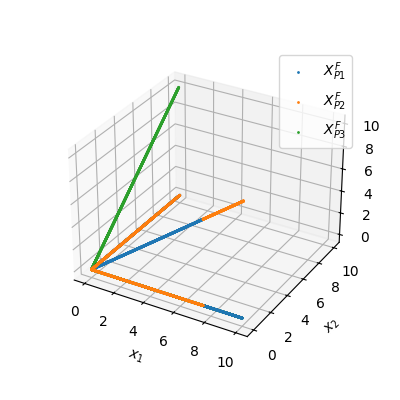

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection='3d')
ax.scatter3D(x_grid[:,0],x_grid[:,1],y_grid[:,0], label = '$X^F_{P1}$', s = 1 )
ax.scatter3D(x_grid[:,0],x_grid[:,1],y_grid[:,1], label = '$X^F_{P2}$', s = 1  )
ax.scatter3D(x_grid[:,0],x_grid[:,1],y_grid[:,2], label = '$X^F_{P3}$', s = 1  )
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend()

# Global hyperparameters 
Its value will not be modified during the tuning process.

In [ ]:
batch_size = 32
tolerance = 1e-10 # Minimum improvement in validation loss to keep training the model
epochs = 200

# Specify model architecture:

In [ ]:
class MyHypermodel(keras_tuner.HyperModel):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def build(self, hp):
        '''
        Method to define the hyperparameter space and call the model building function for each combination of hyperparameters
        '''
        units_h1   = hp.Int("units_h1", min_value = 2**4, max_value = 2**6, step = 2, sampling = 'log')
        units_h2   = hp.Int("units_h2", min_value = 2**4, max_value = 2**5, step = 2, sampling = 'log')
        units_h3   = hp.Int("units_h3", min_value = 2**4, max_value = 2**6, step = 2, sampling = 'log')
        learning_rate = hp.Float("learning_rate", min_value = 1e-4, max_value = 1e-3, step = 10, sampling = 'log')
        optimizer = hp.Choice('optimizer', values = ['Adam','Adadelta'])
        
        return self.build_standard_model(units_h1, units_h2, units_h3, learning_rate, optimizer) 
    
    def build_standard_model(self, units_h1, units_h2, units_h3, learning_rate, optimizer): 
        '''
        Method to separate the network achitecture definition from the search space definition + hypermodel building function
        '''

        model = tf.keras.Sequential([
            tf.keras.Input(shape = (self.input_shape[1],), name = 'IN'),
            tf.keras.layers.Dense(units = units_h1, activation = 'relu', name = 'H1'),
            # tf.keras.layers.Dropout(rate=0.2),
            tf.keras.layers.Dense(units = units_h2, activation = 'relu', name = 'H2'),
            # tf.keras.layers.Dropout(rate=0.2),
            tf.keras.layers.Dense(units = units_h3, activation = 'relu', name = 'H3'),
            # tf.keras.layers.Dropout(rate=0.2),
            tf.keras.layers.Dense(units = self.output_shape[1], activation = 'linear', name = 'OUT')
        ])
    
        if optimizer == 'Adam':
            model.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate))
        if optimizer == 'Adadelta':    
            model.compile(loss = 'mae', optimizer = tf.keras.optimizers.Adadelta())
        
        return model

Set up the tunner and print a summary of the search space.

In [ ]:
hypermodel = MyHypermodel(x_tr.shape, y_tr.shape)
tuner = keras_tuner.Hyperband(
                        hypermodel = hypermodel,
                        objective = 'val_loss',
                        max_epochs = epochs,
                        hyperband_iterations= 2,
                        overwrite = True
                        )
# tuner.search_space_summary()

Run the search, print results and extract the best hyperparameter configuration.

In [ ]:
start_tuning = timer()
tuner.search(   x = x_tr , 
                y = y_tr , 
                epochs = epochs, 
                batch_size = batch_size,
                verbose = 0, 
                validation_data = (x_val, y_val),
                callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta = tolerance)] )
end_tuning = timer()
print(f'Tuning time: {end_tuning-start_tuning:.2f} s')

## The final model
tuner.results_summary()
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hp.values)


Tuning time: 143.48 s
Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0018 summary
Hyperparameters:
units_h1: 64
units_h2: 32
units_h3: 64
learning_rate: 0.001
optimizer: Adam
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.6864668726921082

Trial 0029 summary
Hyperparameters:
units_h1: 64
units_h2: 16
units_h3: 16
learning_rate: 0.001
optimizer: Adam
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.6927680373191833

Trial 0026 summary
Hyperparameters:
units_h1: 32
units_h2: 32
units_h3: 16
learning_rate: 0.001
optimizer: Adam
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.6949737071990967

Trial 0044 summary
Hyperparameters:
units_h1: 16
units_h2: 32
units_h3: 32
learning_rate: 0.001
optimizer: Adam
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.6975129246711731

Trial 0034 summary
Hype

Find the most suitable learning rate for the given architecture.

In [ ]:
hypermodel = MyHypermodel(x_tr.shape, y_tr.shape)
model_lr = hypermodel.build_standard_model(best_hp.get('units_h1'), best_hp.get('units_h2'), best_hp.get('units_h3'), best_hp.get('learning_rate'), best_hp.get('optimizer'))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / (epochs/5)))

history = model_lr.fit(x = x_tr, y = y_tr , epochs = epochs , batch_size = batch_size, verbose = 0, validation_data=(x_val,y_val), callbacks=[lr_schedule])

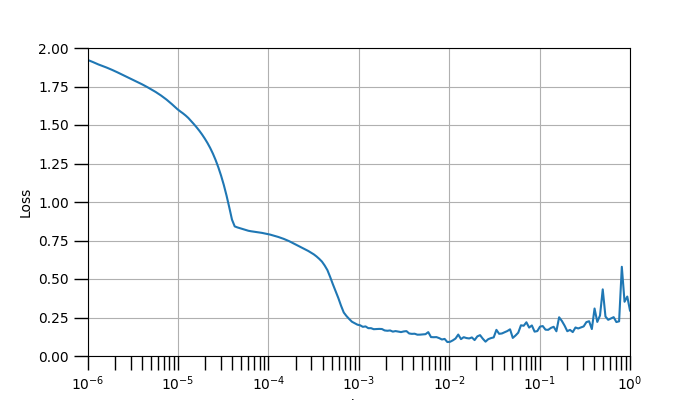

In [ ]:
def plot_loss_vs_learning_rate(history, title = ''):
    # Define the learning rate array
    lrs = 1e-6 * (10 ** (np.array(history.epoch) / (history.epoch[-1]/6)))
    # Set the figure size
    fig = plt.figure(figsize=(7, 4))
    # Set the grid
    plt.grid(True)
    # Plot the loss in log scale
    plt.semilogx(lrs, history.history["loss"])
    # Increase the tickmarks size
    plt.tick_params('both', length=10, width=1, which='both')
    # Set the plot boundaries
    plt.axis([1e-6, 1e0, 0, np.round(max(history.history["loss"]), 0)])
    plt.xlabel('Learning rate')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

plot_loss_vs_learning_rate(history)

Retrain the model with the entire dataset

In [ ]:
learning_rate = 7e-4
model_lr = hypermodel.build_standard_model(best_hp.get('units_h1'), best_hp.get('units_h2'), best_hp.get('units_h3'), learning_rate, best_hp.get('optimizer'))

# Fit with the entire dataset.
x_all = np.concatenate((x_tr, x_val))
y_all = np.concatenate((y_tr, y_val))
history = model_lr.fit(x=x_all, y=y_all, 
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1,
                        validation_data=(x_test, y_test))

predictions_tr = model_lr.predict(x_tr, verbose=0)
predictions_val = model_lr.predict(x_val, verbose=0)
predictions_test = model_lr.predict(x_test, verbose=0)

mse_test = model_lr.evaluate(x_test, y_test, verbose=0) 
mse_train = model_lr.evaluate(x_all, y_all, verbose=0)

print(f'MSE test: {mse_test:.3f}\nMSE train: {mse_train:.3f}')

Epoch 1/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3340 - val_loss: 0.7660
Epoch 2/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7932 - val_loss: 0.6365
Epoch 3/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7377 - val_loss: 0.6258
Epoch 4/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7078 - val_loss: 0.6127
Epoch 5/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6409 - val_loss: 0.5817
Epoch 6/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6193 - val_loss: 0.4768
Epoch 7/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4824 - val_loss: 0.3597
Epoch 8/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3309 - val_loss: 0.2510
Epoch 9/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2221 - val_loss: 0.2048
Epoch 10/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2036 - val_loss: 0.1756
Epoch 11/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1660 - val_loss: 0.1587
Epoch 12/200
141/141 ━━━━━━━━━━━━━━━━━━━━

Plot resutls and evaluate metrics

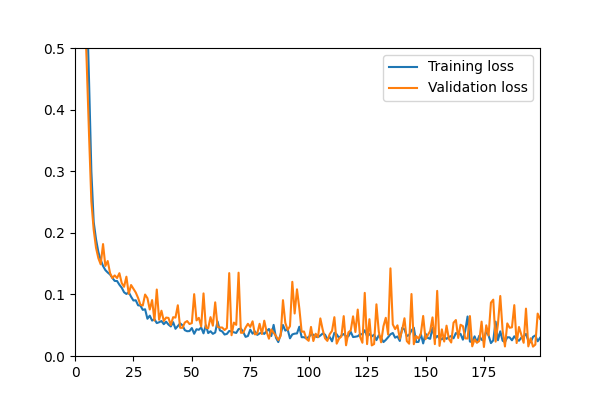

In [ ]:
plot_history(history)

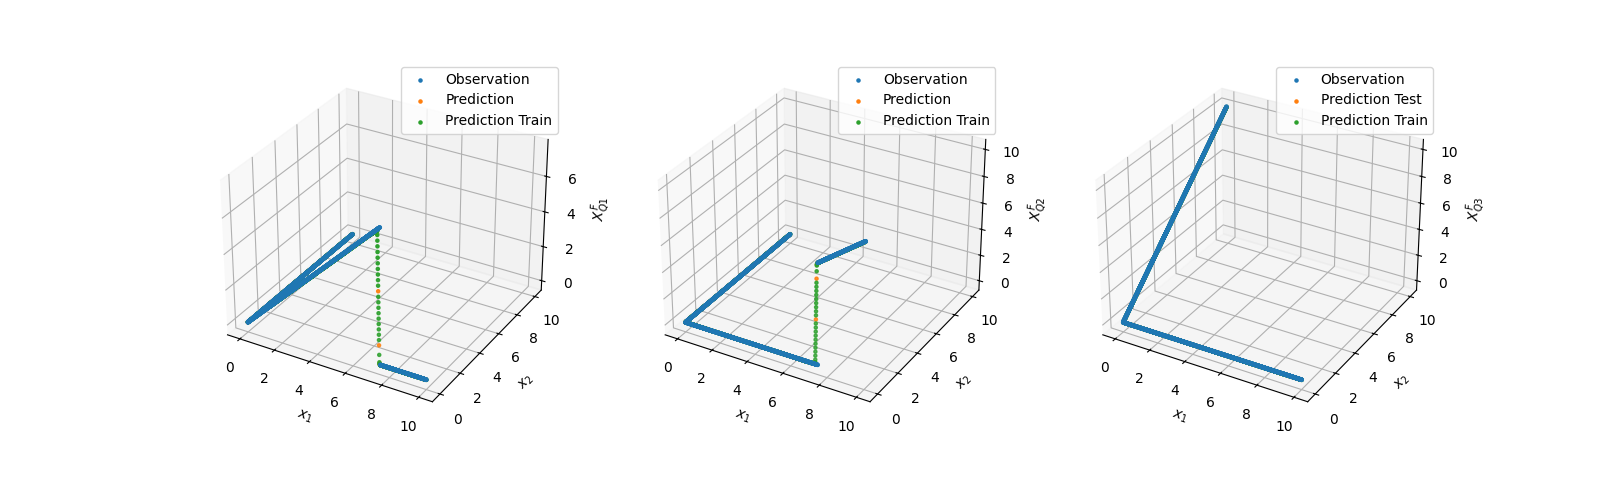

In [ ]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter3D(x_tr[:,0],x_tr[:,1],y_tr[:,0], label = 'Observation', s = 5 )
ax.scatter3D(x_test[:,0],x_test[:,1],predictions_test[:,0], label = 'Prediction', s = 5  )
ax.scatter3D(x_tr[:,0],x_tr[:,1],predictions_tr[:,0], label = 'Prediction Train', s = 5  )
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$X^F_{Q1}$')
ax.legend()

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter3D(x_tr[:,0],x_tr[:,1],y_tr[:,1], label = 'Observation', s = 5 )
ax.scatter3D(x_test[:,0],x_test[:,1],predictions_test[:,1], label = 'Prediction', s = 5  )
ax.scatter3D(x_tr[:,0],x_tr[:,1],predictions_tr[:,1], label = 'Prediction Train', s = 5  )
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$X^F_{Q2}$')
ax.legend()

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter3D(x_tr[:,0],x_tr[:,1],y_tr[:,2], label = 'Observation', s = 5 )
ax.scatter3D(x_test[:,0],x_test[:,1],predictions_test[:,2], label = 'Prediction Test', s = 5  )
ax.scatter3D(x_tr[:,0],x_tr[:,1],predictions_tr[:,2], label = 'Prediction Train', s = 5  )
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$X^F_{Q3}$')
ax.legend()

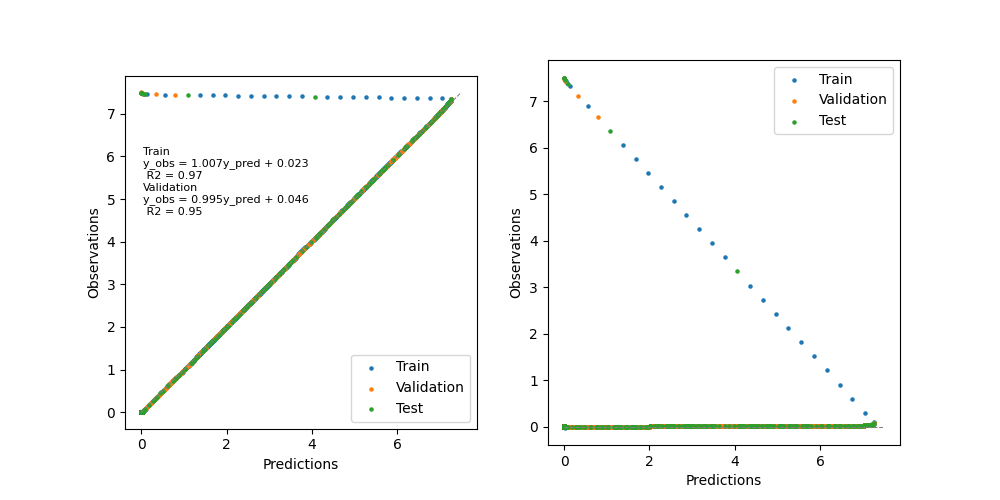

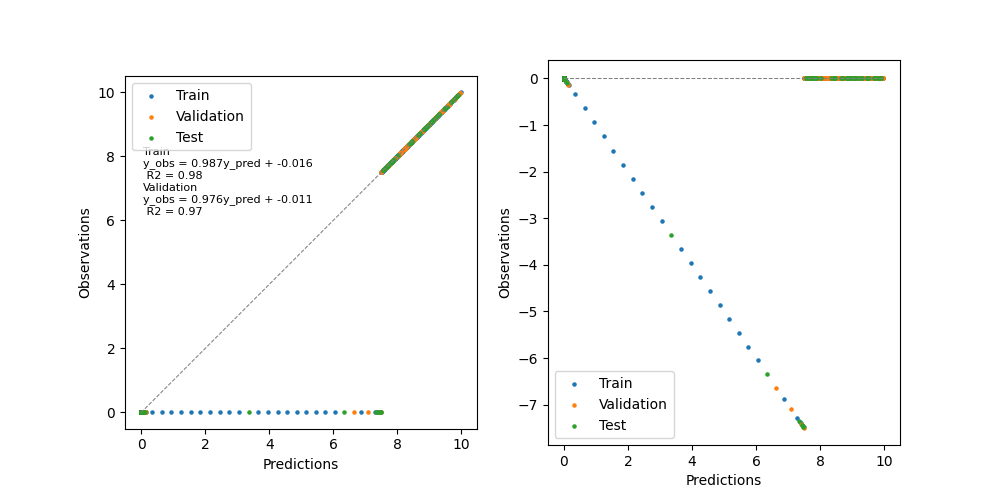

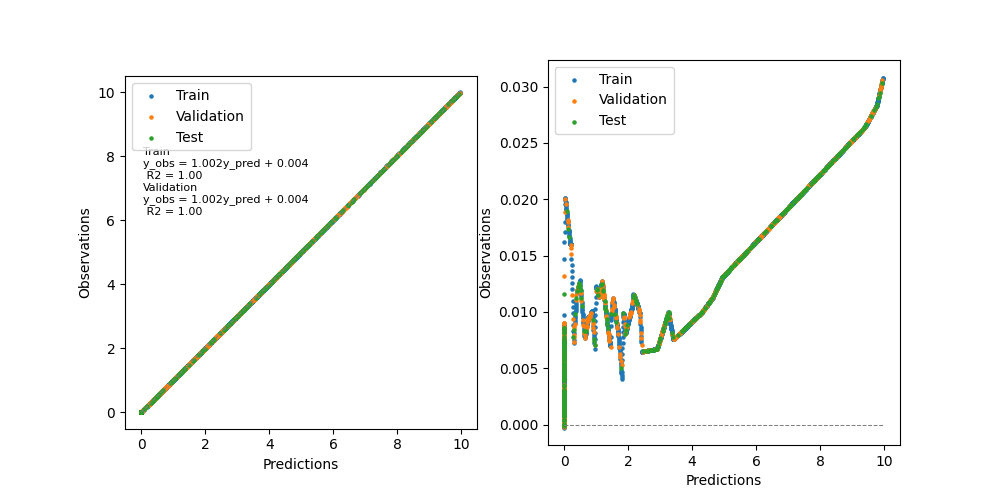

In [ ]:
title = ['$X^F_{Q1}', '$X^F_{Q2}', '$X^F_{Q3}']

plot_predictionerror((predictions_tr[:,0],predictions_val[:,0],predictions_test[:,0]), (y_tr[:,0], y_val[:,0], y_test[:,0]))
plot_predictionerror((predictions_tr[:,1],predictions_val[:,1],predictions_test[:,1]), (y_tr[:,1], y_val[:,1], y_test[:,1]))
plot_predictionerror((predictions_tr[:,2],predictions_val[:,2],predictions_test[:,2]), (y_tr[:,2], y_val[:,2], y_test[:,2]))

In [ ]:
mse_test = model_lr.evaluate(x_test, y_test, verbose=0) 
mse_train = model_lr.evaluate(x_all, y_all, verbose=0)

print(f'MSE test: {mse_test:.3f}\nMSE train: {mse_train:.3f}')

MSE test: 0.060
MSE train: 0.029


# Save model and weights

In [ ]:
model_name = 'nn_ie_240510'
weights_name = 'nn_weights_ie_240510'
file_path = r'H:\My Drive\Files\Illustrative example Fengqi You 2017\nn models'

model_lr.save(model_name + '.keras')
w = model_lr.get_weights()
with open(weights_name,"wb") as file:
    pickle.dump(w,file)

# Solution of the surrogate problem

In [ ]:
from illustrative_example_class import *
from pyomo.environ import *
from pyomo.opt import SolverFactory

@document_kwargs_from_configdict() decorator.  (deprecated in 6.6.0) (called
from c:\Users\Usuario\anaconda3\envs\env_optim\lib\site-
packages\pao\common\solver.py:189)


Evaluate solution with the surrogate optimization problem (the one including NN embedding).

In [ ]:
model_name = 'nn_ie_240510'
nn_model = tf.keras.models.load_model(model_name+'.keras')
with open('illustrative_example_data', 'rb') as f:
    data = pickle.load(f) 

illustrative_example_object = surrogate_problem_class(data)
surrogate_opt_problem = illustrative_example_object.build()
nn_embedding_object = nn_embedding_compact(surrogate_opt_problem, nn_model)
nn_embedding_object.embed_nn_into_parent_opt_problem(surrogate_opt_problem)
surrogate_opt_problem.varCost['F','Q2'] = 10.

Evaluate "analytical" solution (the one obtained with the KKT reformulation)

In [ ]:
bilevelKKT_object = KKTreformulated_problem(data)
bilevelKKT_problem = bilevelKKT_object.build()
bilevelKKT_problem.varCost['F','Q2'] = 10.

In [ ]:
opt = SolverFactory('gams', solver = 'cplex')
start_surrogate = timer()
results_surrogate = opt.solve(surrogate_opt_problem)
end_surrogate = timer()
start_bilevelKKT = timer()
results_bilevelKKT = opt.solve(bilevelKKT_problem)
end_bilevelKKT = timer()

print(f'Profit of the leader:\n Surrogate: {surrogate_opt_problem.obj():.2f} \n Bilevel KKT: {bilevelKKT_problem.obj():.2f}')
print(f'Solution time:\n Surrogate: {end_surrogate-start_surrogate:.2f} s \n Bilevel KKT: {end_bilevelKKT-start_bilevelKKT:.2f} s')
print('Production rate of each leader scheme:\n')
surrogate_opt_problem.X.pprint()
print('Production rate of each follower scheme:\n')
surrogate_opt_problem.beta.pprint()

# results.write()

Profit of the leader:
 Surrogate: 349.71 
 Bilevel KKT: 350.00
Solution time:
 Surrogate: 6.95 s 
 Bilevel KKT: 0.18 s
Production rate of each leader scheme:

X : Size=2, Index=J[L]
    Key : Lower : Value : Upper : Fixed : Stale : Domain
     P1 :     0 :  10.0 :  None : False :  True : NonNegativeReals
     P2 :     0 :   0.0 :  None : False :  True : NonNegativeReals
Production rate of each follower scheme:

beta : Size=3, Index=N[OUT]
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
     Q1 :  None : -0.008685386884946 :  None : False :  True :  Reals
     Q2 :  None :  9.979608863022381 :  None : False :  True :  Reals
     Q3 :  None : -0.009030830313786 :  None : False :  True :  Reals
